## **Carga de librerias y configuraciones**

In [12]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? Y


In [85]:
!cat /proc/meminfo

MemTotal:       32949048 kB
MemFree:        30166392 kB
MemAvailable:   31418476 kB
Buffers:          676068 kB
Cached:           787524 kB
SwapCached:            0 kB
Active:          2088244 kB
Inactive:         331192 kB
Active(anon):     955844 kB
Inactive(anon):       48 kB
Active(file):    1132400 kB
Inactive(file):   331144 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               132 kB
Writeback:             0 kB
AnonPages:        956068 kB
Mapped:           148328 kB
Shmem:                60 kB
Slab:             276328 kB
SReclaimable:     252448 kB
SUnreclaim:        23880 kB
KernelStack:        3936 kB
PageTables:         6992 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    16474524 kB
Committed_AS:    2415608 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import json
import gzip

from sklearn import preprocessing as prp
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (accuracy_score, r2_score, confusion_matrix,
f1_score, recall_score, precision_score)

import os
import boto3
import re

import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# ruta de trabajo en s3
bucket = 'boi-banregio'

# s3 resource
s3_bucket_resource = boto3.resource('s3').Bucket(bucket)

In [3]:
# Aquí colocamos la ruta de nuestro directorio, el nombre de nuestro archivo y si tiene o no cabecera
prefix = 'datalake/data/InteligenciaRiesgos/M&M/MCV/VARIABLES_PEDRO'

data_file_name = "CV_6M/CV_6M.csv"
data_file_name2 = "30+_6M/30+_6M.csv"


# header_file_name = "JAT_MCV_UNIVERSO_MODELADO_PREVIO_labels.csv"
# header_file_name2 = "LABELS/JAT_MCV_VAR_VP2_LABELS.csv"
# header_file_name3 = "LABELS/LGG_MCV_VAR_CR_LABELS.csv"

# Los archivos vienen con o sin encabezado
header = False

target1 = 'CV_6M'
target2 = '30+_6M'
# features =  ['pclass', 'age', 'sibsp', 'parch', 'fare']

# Decidimos si se desea imputar valores nulos con media, mediana o moda de las columnas
# en caso de no querer imputar debe tomarse en cuenta que este algoritmo no funciona con valores nulos
impute = True
strategy = 'mean'   # mean, meadian, most_frequent

# Decidimos si queremos escalar las columnas de caracteríticas de tal forma que posean una distribución normal
scale = True       



In [102]:
algorithm = 'xgboost'

# Configuramos los nombres de nuestra tarea de entrenamiento, configuración de servicio y servicio 
train_job = 'MCV-PVZ-XGBoost-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_config = 'MCV-PVZ-XGBoost-endpoint-config-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint = 'MCV-PVZ-XGBoost-endpoint-' + time.strftime("%Y%m%d%H%M", time.gmtime())

# Configuramos los nombres de nuestra tarea de entrenamiento, configuración de servicio y servicio 
train_job2 = 'MCV-PVZ2-XGBoost-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_config2 = 'MCV-PVZ2-XGBoost-endpoint-config-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint2 = 'MCV-PVZ2-XGBoost-endpoint-' + time.strftime("%Y%m%d%H%M", time.gmtime())


# Hiperparámetros
hyperparameters = {
   "num_round": "100",                     # required
   "max_depth":"5",
   "eta":"0.3",    
   "objective": "binary:logistic",      
   "eval_metric": "auc",
   "nthread": "4",
   "seed": "1"
}



# hyperparameters = {
#     "booster" : "gbtree",
#     "max_depth" : "8",
#     "gamma" : "0.8",
#     "eta" : "0.1",
#     "objective" : "binary:logistic",  #              'nthread' : 4,
#     "silent" : "1",
#     "eval_metric": "auc",
#     "subsample" : "0.8",
#     "colsample_bytree" : "0.8",
#     "min_child_weight" : "0.2",
#     "max_delta_step" : "2",
#     "seed" : "1",
#     "num_round": "200"
#     # "nfold" =5  
# }

 


train_file = '{}_train.csv'.format(algorithm)
val_file = '{}_validation.csv'.format(algorithm)
test_file = '{}_test.csv'.format(algorithm)

version = '0.0.2'

train_obj_key = os.path.join(prefix, 'train', algorithm, version, train_file)
validation_obj_key = os.path.join(prefix, 'validation', algorithm, version, val_file)
test_obj_key = os.path.join(prefix, 'test', algorithm,  version, test_file)

train_file2 = '{}_train.csv'.format(algorithm)
val_file2 = '{}_validation.csv'.format(algorithm)
test_file2 = '{}_test.csv'.format(algorithm)

version2 = '2.0.2'

train_obj_key2 = os.path.join(prefix, 'train', algorithm, version2, train_file2)
validation_obj_key2 = os.path.join(prefix, 'validation', algorithm, version2, val_file2)
test_obj_key2 = os.path.join(prefix, 'test', algorithm,  version2, test_file2)


In [15]:
linear_endpoint = None
linear_endpoint_config = None

In [103]:
role = get_execution_role()

# configuración de datos crudos
data_file_key = "{}/DATASETS/{}".format(prefix, data_file_name)
# header_file_key = "{}/DATASETS/{}".format(prefix, header_file_name)

data_file_key2 = "{}/DATASETS/{}".format(prefix, data_file_name2)
# header_file_key2 = "{}/DATASETS/{}".format(prefix, header_file_name2)

# data_file_key3 = "{}/DATASETS/{}".format(prefix, data_file_name3)
# header_file_key3 = "{}/DATASETS/{}".format(prefix, header_file_name3)

# configuración de datos procesados
output_dir_uri = "https://s3.us-east-1.amazonaws.com/{}/{}/models/{}/{}/".format(bucket, prefix, algorithm, version)
train_dir_uri = "https://s3.us-east-1.amazonaws.com/{}/{}/train/{}/{}/".format(bucket, prefix, algorithm, version)
validation_dir_uri = "https://s3.us-east-1.amazonaws.com/{}/{}/validation/{}/{}/".format(bucket, prefix, algorithm, version)


output_dir_uri2 = "https://s3.us-east-1.amazonaws.com/{}/{}/models/{}/{}/".format(bucket, prefix, algorithm, version2)
train_dir_uri2 = "https://s3.us-east-1.amazonaws.com/{}/{}/train/{}/{}/".format(bucket, prefix, algorithm, version2)
validation_dir_uri2 = "https://s3.us-east-1.amazonaws.com/{}/{}/validation/{}/{}/".format(bucket, prefix, algorithm, version2)

print(data_file_key)
# print(header_file_key)
print(data_file_key2)
# print(header_file_key2)
# print(data_file_key3)
# print(header_file_key3)

datalake/data/InteligenciaRiesgos/M&M/MCV/VARIABLES_PEDRO/DATASETS/CV_6M/CV_6M.csv
datalake/data/InteligenciaRiesgos/M&M/MCV/VARIABLES_PEDRO/DATASETS/30+_6M/30+_6M.csv


## **Craga de datos y preprocesamiento**

### **Puede saltar a "Entrenamiento" en caso de haber preprocesado ya sus datos**

In [8]:
obj = s3_bucket_resource.Object(data_file_key).get()
obj2 = s3_bucket_resource.Object(data_file_key2).get()

df1 = pd.read_csv(
    io.BytesIO(obj['Body'].read())
)

df2 = pd.read_csv(
    io.BytesIO(obj2['Body'].read())
)
print(df1.shape)
print(df2.shape)

(95494, 48)
(95494, 48)


In [9]:
print(df1.shape)
display(df1.columns)
display(df1.head())
display(df1.describe())

print(df2.shape)
display(df2.columns)
display(df2.head())
display(df2.describe())

(95494, 48)


Index(['CV_6M', 'MTO_LIN_RFC', 'LAG_ANTIG', 'T_', 'MET_R', 'CNT_R', 'MET',
       'CNT', 'LAG_LAST_CALIF', 'Cal_Per_11_RNK', 'COMPORT_ACTUAL',
       'COMPORT_HISTORICO', 'Cal_Per_11', 'UTILIZACION_VAL', 'BK12_CLEAN',
       'WB_REV_U12M_25K', 'WB_SMP_U12M_25K', 'max_bucket_12M', 'bucket_1_12M',
       'bucket_2_12M', 'WB_SMP_U12M_25K_R', 'max_bucket_12M_R',
       'Flag_MET_CORP', 'Flag_MET_ATR', 'Flag_MET_ATR1', 'TIPO_', 'CLAS_5',
       'CLAS_8', 'FLAG_TCC', 'FLAG_TCC2', 'TPV', 'TPV_SDO', 'TPV_MSS',
       'GRD_ID_ACT', 'PCT_REV', 'PCT_REV_RNK', 'VCC_REV_SMP', 'VCC_REV_SMP_R',
       'SDO', 'PI', 'UTILIZACION', 'UtilizacionRevolventes', 'BK_DEUDA_TOT',
       'DEUDA_TOT', 'PCT_DBT_BK', 'DT_VS_SD', 'FLAG_DT_VS_SD',
       'CNT_DT_SIN_INF'],
      dtype='object')

,CV_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
0,0,1500000.0,30.0,0,1.0,0.0,1.0,12.0,1.0,0,...,1507110.26,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.0,1.008663,0.0,0
1,0,1500000.0,31.0,0,1.0,0.0,1.0,12.0,1.0,0,...,1506705.18,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.0,1.008391,0.0,0
2,0,1500000.0,32.0,0,1.0,0.0,1.0,12.0,1.0,0,...,1507136.00,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.0,1.008680,0.0,0
3,0,1500000.0,33.0,0,1.0,0.0,1.0,12.0,1.0,0,...,1506742.53,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.0,1.008364,0.0,0
4,0,1500000.0,34.0,0,1.0,0.0,1.0,12.0,1.0,0,...,1507727.85,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.0,1.009023,0.0,0


,CV_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
count,95494.000000,9.472600e+04,95492.000000,95494.000000,94382.000000,94382.000000,94382.000000,94382.000000,94382.000000,95494.000000,...,9.549400e+04,95494.000000,95494.000000,95494.000000,9.450900e+04,9.450900e+04,92939.000000,9.293900e+04,92939.000000,95494.000000
mean,0.005142,2.885371e+07,57.739517,0.103703,1.705632,0.111536,2.283465,10.645918,1.047255,0.981130,...,1.625984e+07,0.032042,0.857841,11.606586,6.326424e+07,7.521328e+07,0.809466,1.183574e+03,0.135982,0.026756
std,0.071521,7.407029e+07,45.292014,0.304876,0.690213,0.314797,1.353648,2.744751,0.486815,1.054741,...,8.795327e+07,0.048911,74.312642,2830.006296,4.662468e+08,5.020840e+08,0.316052,1.461936e+05,0.342771,0.161369
min,0.000000,1.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000e+00,0.004028,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,2.307642e+06,20.000000,0.000000,1.000000,0.000000,1.000000,11.000000,1.000000,0.000000,...,7.100683e+05,0.012749,0.410318,0.006236,1.064804e+06,2.018830e+06,0.764738,1.840413e-01,0.000000,0.000000
50%,0.000000,9.917308e+06,44.000000,0.000000,2.000000,0.000000,2.000000,12.000000,1.000000,1.000000,...,4.909117e+06,0.020898,0.656624,0.447676,7.917764e+06,1.031678e+07,0.992336,5.989855e-01,0.000000,0.000000
75%,0.000000,2.500000e+07,90.000000,0.000000,2.000000,0.000000,3.000000,12.000000,1.000000,1.000000,...,1.456591e+07,0.034364,0.840000,0.890021,3.020468e+07,3.968117e+07,1.000000,9.755760e-01,0.000000,0.000000
max,1.000000,2.130390e+09,164.000000,1.000000,3.000000,1.000000,9.000000,12.000000,12.000000,4.000000,...,6.697353e+09,1.000000,22959.000000,871594.210500,2.309709e+10,2.563488e+10,1.000000,2.503358e+07,1.000000,1.000000


(95494, 48)


Index(['30+_6M', 'MTO_LIN_RFC', 'LAG_ANTIG', 'T_', 'MET_R', 'CNT_R', 'MET',
       'CNT', 'LAG_LAST_CALIF', 'Cal_Per_11_RNK', 'COMPORT_ACTUAL',
       'COMPORT_HISTORICO', 'Cal_Per_11', 'UTILIZACION_VAL', 'BK12_CLEAN',
       'WB_REV_U12M_25K', 'WB_SMP_U12M_25K', 'max_bucket_12M', 'bucket_1_12M',
       'bucket_2_12M', 'WB_SMP_U12M_25K_R', 'max_bucket_12M_R',
       'Flag_MET_CORP', 'Flag_MET_ATR', 'Flag_MET_ATR1', 'TIPO_', 'CLAS_5',
       'CLAS_8', 'FLAG_TCC', 'FLAG_TCC2', 'TPV', 'TPV_SDO', 'TPV_MSS',
       'GRD_ID_ACT', 'PCT_REV', 'PCT_REV_RNK', 'VCC_REV_SMP', 'VCC_REV_SMP_R',
       'SDO', 'PI', 'UTILIZACION', 'UtilizacionRevolventes', 'BK_DEUDA_TOT',
       'DEUDA_TOT', 'PCT_DBT_BK', 'DT_VS_SD', 'FLAG_DT_VS_SD',
       'CNT_DT_SIN_INF'],
      dtype='object')

,30+_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
0,0,1500000.0,30.0,0,1.0,0.0,1.0,12.0,1.0,0,...,1507110.26,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.0,1.008663,0.0,0
1,0,1500000.0,31.0,0,1.0,0.0,1.0,12.0,1.0,0,...,1506705.18,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.0,1.008391,0.0,0
2,0,1500000.0,32.0,0,1.0,0.0,1.0,12.0,1.0,0,...,1507136.00,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.0,1.008680,0.0,0
3,0,1500000.0,33.0,0,1.0,0.0,1.0,12.0,1.0,0,...,1506742.53,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.0,1.008364,0.0,0
4,0,1500000.0,34.0,0,1.0,0.0,1.0,12.0,1.0,0,...,1507727.85,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.0,1.009023,0.0,0


,30+_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
count,95494.000000,9.472600e+04,95492.000000,95494.000000,94382.000000,94382.000000,94382.000000,94382.000000,94382.000000,95494.000000,...,9.549400e+04,95494.000000,95494.000000,95494.000000,9.450900e+04,9.450900e+04,92939.000000,9.293900e+04,92939.000000,95494.000000
mean,0.015467,2.885371e+07,57.739517,0.103703,1.705632,0.111536,2.283465,10.645918,1.047255,0.981130,...,1.625984e+07,0.032042,0.857841,11.606586,6.326424e+07,7.521328e+07,0.809466,1.183574e+03,0.135982,0.026756
std,0.123401,7.407029e+07,45.292014,0.304876,0.690213,0.314797,1.353648,2.744751,0.486815,1.054741,...,8.795327e+07,0.048911,74.312642,2830.006296,4.662468e+08,5.020840e+08,0.316052,1.461936e+05,0.342771,0.161369
min,0.000000,1.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000e+00,0.004028,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,2.307642e+06,20.000000,0.000000,1.000000,0.000000,1.000000,11.000000,1.000000,0.000000,...,7.100683e+05,0.012749,0.410318,0.006236,1.064804e+06,2.018830e+06,0.764738,1.840413e-01,0.000000,0.000000
50%,0.000000,9.917308e+06,44.000000,0.000000,2.000000,0.000000,2.000000,12.000000,1.000000,1.000000,...,4.909117e+06,0.020898,0.656624,0.447676,7.917764e+06,1.031678e+07,0.992336,5.989855e-01,0.000000,0.000000
75%,0.000000,2.500000e+07,90.000000,0.000000,2.000000,0.000000,3.000000,12.000000,1.000000,1.000000,...,1.456591e+07,0.034364,0.840000,0.890021,3.020468e+07,3.968117e+07,1.000000,9.755760e-01,0.000000,0.000000
max,1.000000,2.130390e+09,164.000000,1.000000,3.000000,1.000000,9.000000,12.000000,12.000000,4.000000,...,6.697353e+09,1.000000,22959.000000,871594.210500,2.309709e+10,2.563488e+10,1.000000,2.503358e+07,1.000000,1.000000


In [21]:
#df = df.replace(to_replace='\\N', value=np.nan)
display(df1.iloc[range(0,30), range(30, 48)])

display(df2.iloc[range(0,30), range(30, 48)])

# [target] + list(features)

,TPV,TPV_SDO,TPV_MSS,GRD_ID_ACT,PCT_REV,PCT_REV_RNK,VCC_REV_SMP,VCC_REV_SMP_R,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
0,0.0,0.0,0.0,1.0,1.0,1.0,2.993523,1.0,1507110.26,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.000000,1.008663,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,1.0,2.993523,1.0,1506705.18,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.000000,1.008391,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,1.0,2.993523,1.0,1507136.00,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.000000,1.008680,0.0,0.0
3,0.0,0.0,0.0,2.0,1.0,1.0,2.993523,1.0,1506742.53,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.000000,1.008364,0.0,0.0
4,0.0,0.0,0.0,2.0,1.0,1.0,2.993523,1.0,1507727.85,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.000000,1.009023,0.0,0.0
5,0.0,0.0,0.0,2.0,1.0,1.0,2.993523,1.0,1507792.18,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.000000,1.009066,0.0,0.0
6,0.0,0.0,0.0,2.0,1.0,1.0,2.993523,1.0,1509361.89,0.044482,0.996111,0.996111,1502848.0,1502848.0,1.000000,1.004334,0.0,0.0
7,0.0,0.0,0.0,2.0,1.0,1.0,2.993523,1.0,1509773.62,0.044482,0.996111,0.996111,1502848.0,1502848.0,1.000000,1.004608,0.0,0.0
8,0.0,0.0,0.0,2.0,1.0,1.0,2.993523,1.0,1508600.28,0.044482,0.996111,0.996111,1502848.0,1502848.0,1.000000,1.003828,0.0,0.0
9,0.0,0.0,0.0,1.0,1.0,1.0,2.993523,1.0,1510416.94,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.000000,1.010876,0.0,0.0


,TPV,TPV_SDO,TPV_MSS,GRD_ID_ACT,PCT_REV,PCT_REV_RNK,VCC_REV_SMP,VCC_REV_SMP_R,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
0,0.0,0.0,0.0,1.0,1.0,1.0,2.993523,1.0,1507110.26,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.000000,1.008663,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,1.0,2.993523,1.0,1506705.18,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.000000,1.008391,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,1.0,2.993523,1.0,1507136.00,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.000000,1.008680,0.0,0.0
3,0.0,0.0,0.0,2.0,1.0,1.0,2.993523,1.0,1506742.53,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.000000,1.008364,0.0,0.0
4,0.0,0.0,0.0,2.0,1.0,1.0,2.993523,1.0,1507727.85,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.000000,1.009023,0.0,0.0
5,0.0,0.0,0.0,2.0,1.0,1.0,2.993523,1.0,1507792.18,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.000000,1.009066,0.0,0.0
6,0.0,0.0,0.0,2.0,1.0,1.0,2.993523,1.0,1509361.89,0.044482,0.996111,0.996111,1502848.0,1502848.0,1.000000,1.004334,0.0,0.0
7,0.0,0.0,0.0,2.0,1.0,1.0,2.993523,1.0,1509773.62,0.044482,0.996111,0.996111,1502848.0,1502848.0,1.000000,1.004608,0.0,0.0
8,0.0,0.0,0.0,2.0,1.0,1.0,2.993523,1.0,1508600.28,0.044482,0.996111,0.996111,1502848.0,1502848.0,1.000000,1.003828,0.0,0.0
9,0.0,0.0,0.0,1.0,1.0,1.0,2.993523,1.0,1510416.94,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.000000,1.010876,0.0,0.0


In [20]:
# select features and target if needed

# df = df.loc[:, [t]
# impute nans
if impute:
    feats1 = df1.iloc[:, 1:]
    imputer1 = prp.Imputer(missing_values='NaN', strategy=strategy, axis=0)
    imputer1 = imputer1.fit(feats1)
    df1.iloc[:, 1:] = imputer1.transform(feats1)
    
    imputer2 = prp.Imputer(missing_values='NaN', strategy=strategy, axis=0)
    imputer2 = imputer2.fit(df2.iloc[:, 1:])
    df2.iloc[:, 1:] = imputer2.transform(df2.iloc[:, 1:])



,CV_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
count,95494.000000,9.549400e+04,95494.000000,95494.000000,95494.000000,95494.000000,95494.000000,95494.000000,95494.000000,95494.000000,...,9.549400e+04,95494.000000,95494.000000,95494.000000,9.549400e+04,9.549400e+04,95494.000000,9.549400e+04,95494.000000,95494.000000
mean,0.005142,2.885371e+07,57.739517,0.103703,1.705632,0.111536,2.283465,10.645918,1.047255,0.981130,...,1.625984e+07,0.032042,0.857841,11.606586,6.326424e+07,7.521328e+07,0.809466,1.183574e+03,0.135982,0.026756
std,0.071521,7.377184e+07,45.291540,0.304876,0.686183,0.312958,1.345743,2.728723,0.483972,1.054741,...,8.795327e+07,0.048911,74.312642,2830.006296,4.638359e+08,4.994878e+08,0.311795,1.442246e+05,0.338154,0.161369
min,0.000000,1.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000e+00,0.004028,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,2.369705e+06,20.000000,0.000000,1.000000,0.000000,1.000000,11.000000,1.000000,0.000000,...,7.100683e+05,0.012749,0.410318,0.006236,1.109521e+06,2.058154e+06,0.780734,1.935275e-01,0.000000,0.000000
50%,0.000000,1.000000e+07,44.000000,0.000000,2.000000,0.000000,2.000000,12.000000,1.000000,1.000000,...,4.909117e+06,0.020898,0.656624,0.447676,8.080334e+06,1.057835e+07,0.988850,6.251707e-01,0.000000,0.000000
75%,0.000000,2.555421e+07,90.000000,0.000000,2.000000,0.000000,3.000000,12.000000,1.000000,1.000000,...,1.456591e+07,0.034364,0.840000,0.890021,3.196658e+07,4.147133e+07,1.000000,9.894208e-01,0.000000,0.000000
max,1.000000,2.130390e+09,164.000000,1.000000,3.000000,1.000000,9.000000,12.000000,12.000000,4.000000,...,6.697353e+09,1.000000,22959.000000,871594.210500,2.309709e+10,2.563488e+10,1.000000,2.503358e+07,1.000000,1.000000


,CV_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
0,0,1500000.0,30.0,0.0,1.0,0.0,1.0,12.0,1.0,0.0,...,1507110.26,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.0,1.008663,0.0,0.0
1,0,1500000.0,31.0,0.0,1.0,0.0,1.0,12.0,1.0,0.0,...,1506705.18,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.0,1.008391,0.0,0.0
2,0,1500000.0,32.0,0.0,1.0,0.0,1.0,12.0,1.0,0.0,...,1507136.00,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.0,1.008680,0.0,0.0
3,0,1500000.0,33.0,0.0,1.0,0.0,1.0,12.0,1.0,0.0,...,1506742.53,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.0,1.008364,0.0,0.0
4,0,1500000.0,34.0,0.0,1.0,0.0,1.0,12.0,1.0,0.0,...,1507727.85,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.0,1.009023,0.0,0.0


,30+_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
count,95494.000000,9.549400e+04,95494.000000,95494.000000,95494.000000,95494.000000,95494.000000,95494.000000,95494.000000,95494.000000,...,9.549400e+04,95494.000000,95494.000000,95494.000000,9.549400e+04,9.549400e+04,95494.000000,9.549400e+04,95494.000000,95494.000000
mean,0.015467,2.885371e+07,57.739517,0.103703,1.705632,0.111536,2.283465,10.645918,1.047255,0.981130,...,1.625984e+07,0.032042,0.857841,11.606586,6.326424e+07,7.521328e+07,0.809466,1.183574e+03,0.135982,0.026756
std,0.123401,7.377184e+07,45.291540,0.304876,0.686183,0.312958,1.345743,2.728723,0.483972,1.054741,...,8.795327e+07,0.048911,74.312642,2830.006296,4.638359e+08,4.994878e+08,0.311795,1.442246e+05,0.338154,0.161369
min,0.000000,1.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000e+00,0.004028,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,2.369705e+06,20.000000,0.000000,1.000000,0.000000,1.000000,11.000000,1.000000,0.000000,...,7.100683e+05,0.012749,0.410318,0.006236,1.109521e+06,2.058154e+06,0.780734,1.935275e-01,0.000000,0.000000
50%,0.000000,1.000000e+07,44.000000,0.000000,2.000000,0.000000,2.000000,12.000000,1.000000,1.000000,...,4.909117e+06,0.020898,0.656624,0.447676,8.080334e+06,1.057835e+07,0.988850,6.251707e-01,0.000000,0.000000
75%,0.000000,2.555421e+07,90.000000,0.000000,2.000000,0.000000,3.000000,12.000000,1.000000,1.000000,...,1.456591e+07,0.034364,0.840000,0.890021,3.196658e+07,4.147133e+07,1.000000,9.894208e-01,0.000000,0.000000
max,1.000000,2.130390e+09,164.000000,1.000000,3.000000,1.000000,9.000000,12.000000,12.000000,4.000000,...,6.697353e+09,1.000000,22959.000000,871594.210500,2.309709e+10,2.563488e+10,1.000000,2.503358e+07,1.000000,1.000000


,30+_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
0,0,1500000.0,30.0,0.0,1.0,0.0,1.0,12.0,1.0,0.0,...,1507110.26,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.0,1.008663,0.0,0.0
1,0,1500000.0,31.0,0.0,1.0,0.0,1.0,12.0,1.0,0.0,...,1506705.18,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.0,1.008391,0.0,0.0
2,0,1500000.0,32.0,0.0,1.0,0.0,1.0,12.0,1.0,0.0,...,1507136.00,0.036435,0.996111,0.996111,1494167.0,1494167.0,1.0,1.008680,0.0,0.0
3,0,1500000.0,33.0,0.0,1.0,0.0,1.0,12.0,1.0,0.0,...,1506742.53,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.0,1.008364,0.0,0.0
4,0,1500000.0,34.0,0.0,1.0,0.0,1.0,12.0,1.0,0.0,...,1507727.85,0.054206,0.933903,0.933903,1494245.0,1494245.0,1.0,1.009023,0.0,0.0


In [24]:
# TODO: manage categorical variables
display(df1.describe())
display(df1.head())

display(df2.describe())
display(df2.head())

,CV_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
count,95494.000000,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,...,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04
mean,0.005142,3.786575e-16,-8.878798e-16,-2.477550e-15,-1.326231e-14,8.613070e-16,-1.545475e-14,8.982676e-17,2.369634e-15,2.291631e-15,...,-5.432878e-17,3.094409e-16,4.106432e-17,-8.853706e-17,-6.121245e-16,-3.058176e-16,5.892000e-15,1.204043e-17,7.665158e-15,-1.749240e-16
std,0.071521,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,0.000000,-3.911229e-01,-1.274848e+00,-3.401491e-01,-1.028350e+00,-3.563947e-01,-1.696815e+00,-3.534976e+00,-9.763994e-02,-9.302137e-01,...,-1.848701e-01,-5.727613e-01,-1.154373e-02,-4.101279e-03,-1.363943e-01,-1.505816e-01,-2.596163e+00,-8.206512e-03,-4.021312e-01,-1.658046e-01
25%,0.000000,-3.590007e-01,-8.332619e-01,-3.401491e-01,-1.028350e+00,-3.563947e-01,-9.537272e-01,1.297619e-01,-9.763994e-02,-9.302137e-01,...,-1.767968e-01,-3.944593e-01,-6.022195e-03,-4.099076e-03,-1.340022e-01,-1.464610e-01,-9.214949e-02,-8.205170e-03,-4.021312e-01,-1.658046e-01
50%,0.000000,-2.555691e-01,-3.033588e-01,-3.401491e-01,4.289951e-01,-3.563947e-01,-2.106394e-01,4.962356e-01,-9.763994e-02,1.789102e-02,...,-1.290547e-01,-2.278373e-01,-2.707721e-03,-3.943090e-03,-1.189735e-01,-1.294031e-01,5.753296e-01,-8.202177e-03,-4.021312e-01,-1.658046e-01
75%,0.000000,-4.472590e-02,7.122887e-01,-3.401491e-01,4.289951e-01,-3.563947e-01,5.324483e-01,4.962356e-01,-9.763994e-02,1.789102e-02,...,-1.925960e-02,4.747671e-02,-2.400799e-04,-3.786783e-03,-6.747608e-02,-6.755345e-02,6.110919e-01,-8.199651e-03,-4.021312e-01,-1.658046e-01
max,1.000000,2.848712e+01,2.346156e+00,2.939887e+00,1.886340e+00,2.838936e+00,4.990975e+00,4.962356e-01,2.263105e+01,2.862205e+00,...,7.596224e+01,1.979016e+01,3.089415e+02,3.079806e+02,4.965970e+01,5.117203e+01,6.110919e-01,1.735663e+02,2.555114e+00,6.031197e+00


,CV_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
0,0,-0.37079,-0.612469,-0.340149,-1.02835,-0.356395,-0.953727,0.496236,-0.09764,-0.930214,...,-0.167735,0.089807,0.001861,-0.003749,-0.133173,-0.14759,0.611092,-0.0082,-0.402131,-0.165805
1,0,-0.37079,-0.590390,-0.340149,-1.02835,-0.356395,-0.953727,0.496236,-0.09764,-0.930214,...,-0.167739,0.089807,0.001861,-0.003749,-0.133173,-0.14759,0.611092,-0.0082,-0.402131,-0.165805
2,0,-0.37079,-0.568310,-0.340149,-1.02835,-0.356395,-0.953727,0.496236,-0.09764,-0.930214,...,-0.167734,0.089807,0.001861,-0.003749,-0.133173,-0.14759,0.611092,-0.0082,-0.402131,-0.165805
3,0,-0.37079,-0.546231,-0.340149,-1.02835,-0.356395,-0.953727,0.496236,-0.09764,-0.930214,...,-0.167739,0.453148,0.001024,-0.003771,-0.133173,-0.14759,0.611092,-0.0082,-0.402131,-0.165805
4,0,-0.37079,-0.524152,-0.340149,-1.02835,-0.356395,-0.953727,0.496236,-0.09764,-0.930214,...,-0.167728,0.453148,0.001024,-0.003771,-0.133173,-0.14759,0.611092,-0.0082,-0.402131,-0.165805


,30+_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
count,95494.000000,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,...,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04,9.549400e+04
mean,0.015467,3.786575e-16,-8.878798e-16,-2.477550e-15,-1.326231e-14,8.613070e-16,-1.545475e-14,8.982676e-17,2.369634e-15,2.291631e-15,...,-5.432878e-17,3.094409e-16,4.106432e-17,-8.853706e-17,-6.121245e-16,-3.058176e-16,5.892000e-15,1.204043e-17,7.665158e-15,-1.749240e-16
std,0.123401,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,0.000000,-3.911229e-01,-1.274848e+00,-3.401491e-01,-1.028350e+00,-3.563947e-01,-1.696815e+00,-3.534976e+00,-9.763994e-02,-9.302137e-01,...,-1.848701e-01,-5.727613e-01,-1.154373e-02,-4.101279e-03,-1.363943e-01,-1.505816e-01,-2.596163e+00,-8.206512e-03,-4.021312e-01,-1.658046e-01
25%,0.000000,-3.590007e-01,-8.332619e-01,-3.401491e-01,-1.028350e+00,-3.563947e-01,-9.537272e-01,1.297619e-01,-9.763994e-02,-9.302137e-01,...,-1.767968e-01,-3.944593e-01,-6.022195e-03,-4.099076e-03,-1.340022e-01,-1.464610e-01,-9.214949e-02,-8.205170e-03,-4.021312e-01,-1.658046e-01
50%,0.000000,-2.555691e-01,-3.033588e-01,-3.401491e-01,4.289951e-01,-3.563947e-01,-2.106394e-01,4.962356e-01,-9.763994e-02,1.789102e-02,...,-1.290547e-01,-2.278373e-01,-2.707721e-03,-3.943090e-03,-1.189735e-01,-1.294031e-01,5.753296e-01,-8.202177e-03,-4.021312e-01,-1.658046e-01
75%,0.000000,-4.472590e-02,7.122887e-01,-3.401491e-01,4.289951e-01,-3.563947e-01,5.324483e-01,4.962356e-01,-9.763994e-02,1.789102e-02,...,-1.925960e-02,4.747671e-02,-2.400799e-04,-3.786783e-03,-6.747608e-02,-6.755345e-02,6.110919e-01,-8.199651e-03,-4.021312e-01,-1.658046e-01
max,1.000000,2.848712e+01,2.346156e+00,2.939887e+00,1.886340e+00,2.838936e+00,4.990975e+00,4.962356e-01,2.263105e+01,2.862205e+00,...,7.596224e+01,1.979016e+01,3.089415e+02,3.079806e+02,4.965970e+01,5.117203e+01,6.110919e-01,1.735663e+02,2.555114e+00,6.031197e+00


,30+_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
0,0,-0.37079,-0.612469,-0.340149,-1.02835,-0.356395,-0.953727,0.496236,-0.09764,-0.930214,...,-0.167735,0.089807,0.001861,-0.003749,-0.133173,-0.14759,0.611092,-0.0082,-0.402131,-0.165805
1,0,-0.37079,-0.590390,-0.340149,-1.02835,-0.356395,-0.953727,0.496236,-0.09764,-0.930214,...,-0.167739,0.089807,0.001861,-0.003749,-0.133173,-0.14759,0.611092,-0.0082,-0.402131,-0.165805
2,0,-0.37079,-0.568310,-0.340149,-1.02835,-0.356395,-0.953727,0.496236,-0.09764,-0.930214,...,-0.167734,0.089807,0.001861,-0.003749,-0.133173,-0.14759,0.611092,-0.0082,-0.402131,-0.165805
3,0,-0.37079,-0.546231,-0.340149,-1.02835,-0.356395,-0.953727,0.496236,-0.09764,-0.930214,...,-0.167739,0.453148,0.001024,-0.003771,-0.133173,-0.14759,0.611092,-0.0082,-0.402131,-0.165805
4,0,-0.37079,-0.524152,-0.340149,-1.02835,-0.356395,-0.953727,0.496236,-0.09764,-0.930214,...,-0.167728,0.453148,0.001024,-0.003771,-0.133173,-0.14759,0.611092,-0.0082,-0.402131,-0.165805


In [23]:

# normal distributed
if scale:
    df1.iloc[:, 1:] = prp.StandardScaler().fit_transform(df1.iloc[:, 1:])
    df2.iloc[:, 1:] = prp.StandardScaler().fit_transform(df2.iloc[:, 1:])

## **Conjuntos de datos**

In [25]:
np.random.seed(0)
rand_split = np.random.rand(len(df1))
train_list = rand_split < 0.6
val_list = (rand_split >= 0.6) & (rand_split < 0.8)
test_list = rand_split >= 0.8

data_train = df1[train_list]
data_val = df1[val_list]
data_test = df1[test_list]

train_y = data_train.loc[:,target1].values
train_X = data_train.iloc[:,1:].values

val_y = data_val.loc[:,target1].values
val_X = data_val.iloc[:,1:].values

test_y = data_test.loc[:,target1].values
test_X = data_test.iloc[:,1:].values

data_train2 = df2[train_list]
data_val2 = df2[val_list]
data_test2 = df2[test_list]

train_y2 = data_train2.loc[:,target2].values
train_X2 = data_train2.iloc[:,1:].values

val_y2 = data_val2.loc[:,target2].values
val_X2 = data_val2.iloc[:,1:].values

test_y2 = data_test2.loc[:,target2].values
test_X2 = data_test2.iloc[:,1:].values

In [29]:
# describe training data
display(data_train.describe())

# describe validation data
display(data_val.describe())

# describe test data
display(data_test.describe())

,CV_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
count,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,...,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000
mean,0.004995,0.003906,0.000135,0.001693,0.003763,-0.001694,-0.000909,-0.000164,0.001967,0.001604,...,-0.000663,0.003621,0.002176,0.002259,-0.001599,-0.000971,0.001502,-0.004500,-0.000911,0.002559
std,0.070500,1.003739,1.002024,1.002205,1.003345,0.997876,1.000152,0.998949,1.017038,1.000072,...,0.875456,1.021618,1.289098,1.288837,0.974398,0.982817,0.997983,0.287036,0.998815,1.007484
min,0.000000,-0.391123,-1.274848,-0.340149,-1.028350,-0.356395,-1.696815,-3.534976,-0.097640,-0.930214,...,-0.184870,-0.572761,-0.011544,-0.004101,-0.136394,-0.150582,-2.596163,-0.008207,-0.402131,-0.165805
25%,0.000000,-0.358590,-0.833262,-0.340149,-1.028350,-0.356395,-0.953727,0.129762,-0.097640,-0.930214,...,-0.176550,-0.394459,-0.005998,-0.004099,-0.133958,-0.146379,-0.091630,-0.008205,-0.402131,-0.165805
50%,0.000000,-0.255569,-0.303359,-0.340149,0.428995,-0.356395,-0.210639,0.496236,-0.097640,0.017891,...,-0.128451,-0.227837,-0.002676,-0.003944,-0.118774,-0.129059,0.575507,-0.008202,-0.402131,-0.165805
75%,0.000000,-0.038820,0.712289,-0.340149,0.428995,-0.356395,0.532448,0.496236,-0.097640,0.017891,...,-0.017548,0.050422,-0.000222,-0.003786,-0.066347,-0.066384,0.611092,-0.008200,-0.402131,-0.165805
max,1.000000,28.487122,2.346156,2.939887,1.886340,2.838936,4.990975,0.496236,22.631055,2.862205,...,74.610228,19.790162,308.941546,307.980646,49.659697,51.172026,0.611092,34.835882,2.555114,6.031197


,CV_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
count,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,...,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000
mean,0.005179,-0.015946,0.006062,0.005154,-0.005022,0.008395,0.007785,0.000567,-0.010628,-0.002001,...,0.002121,-0.007918,-0.003414,-0.003264,-0.002349,-0.004054,0.000155,0.011575,-0.001571,-0.002053
std,0.071782,0.927236,0.996807,1.006691,0.992845,1.010685,1.001003,1.002611,0.932767,1.001559,...,1.221240,0.953215,0.004050,0.043193,0.947406,0.918448,0.999441,1.788518,0.998503,0.993984
min,0.000000,-0.391119,-1.274848,-0.340149,-1.028350,-0.356395,-0.953727,-3.534976,-0.097640,-0.930214,...,-0.184870,-0.572761,-0.011544,-0.004101,-0.136394,-0.150582,-2.596163,-0.008207,-0.402131,-0.165805
25%,0.000000,-0.358435,-0.811183,-0.340149,-1.028350,-0.356395,-0.953727,0.129762,-0.097640,-0.930214,...,-0.176951,-0.398716,-0.006106,-0.004099,-0.134073,-0.146503,-0.087570,-0.008205,-0.402131,-0.165805
50%,0.000000,-0.255569,-0.281280,-0.340149,0.428995,-0.356395,-0.210639,0.496236,-0.097640,0.017891,...,-0.130748,-0.230007,-0.002784,-0.003942,-0.119191,-0.129808,0.573750,-0.008202,-0.402131,-0.165805
75%,0.000000,-0.051967,0.712289,-0.340149,0.428995,-0.356395,0.532448,0.496236,-0.097640,0.017891,...,-0.021575,0.041622,-0.000282,-0.003787,-0.069192,-0.069178,0.611092,-0.008200,-0.402131,-0.165805
max,1.000000,27.360508,2.346156,2.939887,1.886340,2.838936,4.990975,0.496236,22.631055,2.862205,...,75.734152,16.485800,0.051048,3.344319,43.034710,42.527636,0.611092,173.565758,2.555114,6.031197


,CV_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
count,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,...,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000
mean,0.005545,0.004044,-0.006407,-0.010189,-0.006340,-0.003217,-0.004974,-0.000067,0.004609,-0.002841,...,-0.000108,-0.003046,-0.003160,-0.003560,0.007133,0.006932,-0.004666,0.002069,0.004293,-0.005660
std,0.074261,1.056472,0.997101,0.986639,0.997006,0.995769,0.998583,1.000648,1.012592,0.998307,...,1.102627,0.979358,0.028763,0.031911,1.119557,1.121323,1.006652,1.257613,1.005095,0.983270
min,0.000000,-0.391119,-1.274848,-0.340149,-1.028350,-0.356395,-1.696815,-3.534976,-0.097640,-0.930214,...,-0.184870,-0.572761,-0.011544,-0.004101,-0.136394,-0.150582,-2.596163,-0.008207,-0.402131,-0.165805
25%,0.000000,-0.359687,-0.833262,-0.340149,-1.028350,-0.356395,-0.953727,0.129762,-0.097640,-0.930214,...,-0.177220,-0.394459,-0.006031,-0.004099,-0.134068,-0.146570,-0.098772,-0.008205,-0.402131,-0.165805
50%,0.000000,-0.255569,-0.303359,-0.340149,0.428995,-0.356395,-0.210639,0.496236,-0.097640,0.017891,...,-0.129849,-0.227837,-0.002711,-0.003945,-0.119135,-0.129905,0.576227,-0.008202,-0.402131,-0.165805
75%,0.000000,-0.045461,0.712289,-0.340149,0.428995,-0.356395,0.532448,0.496236,-0.097640,0.017891,...,-0.021807,0.047771,-0.000257,-0.003787,-0.069360,-0.068711,0.611092,-0.008200,-0.402131,-0.165805
max,1.000000,26.785367,2.346156,2.939887,1.886340,2.838936,4.990975,0.496236,22.631055,2.862205,...,75.962244,16.238681,3.931278,3.344319,49.659697,51.172026,0.611092,173.566336,2.555114,6.031197


In [28]:
# describe training data
display(data_train2.describe())

# describe validation data
display(data_val2.describe())

# describe test data
display(data_test2.describe())

,30+_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
count,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,...,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000,57456.000000
mean,0.015525,0.003906,0.000135,0.001693,0.003763,-0.001694,-0.000909,-0.000164,0.001967,0.001604,...,-0.000663,0.003621,0.002176,0.002259,-0.001599,-0.000971,0.001502,-0.004500,-0.000911,0.002559
std,0.123629,1.003739,1.002024,1.002205,1.003345,0.997876,1.000152,0.998949,1.017038,1.000072,...,0.875456,1.021618,1.289098,1.288837,0.974398,0.982817,0.997983,0.287036,0.998815,1.007484
min,0.000000,-0.391123,-1.274848,-0.340149,-1.028350,-0.356395,-1.696815,-3.534976,-0.097640,-0.930214,...,-0.184870,-0.572761,-0.011544,-0.004101,-0.136394,-0.150582,-2.596163,-0.008207,-0.402131,-0.165805
25%,0.000000,-0.358590,-0.833262,-0.340149,-1.028350,-0.356395,-0.953727,0.129762,-0.097640,-0.930214,...,-0.176550,-0.394459,-0.005998,-0.004099,-0.133958,-0.146379,-0.091630,-0.008205,-0.402131,-0.165805
50%,0.000000,-0.255569,-0.303359,-0.340149,0.428995,-0.356395,-0.210639,0.496236,-0.097640,0.017891,...,-0.128451,-0.227837,-0.002676,-0.003944,-0.118774,-0.129059,0.575507,-0.008202,-0.402131,-0.165805
75%,0.000000,-0.038820,0.712289,-0.340149,0.428995,-0.356395,0.532448,0.496236,-0.097640,0.017891,...,-0.017548,0.050422,-0.000222,-0.003786,-0.066347,-0.066384,0.611092,-0.008200,-0.402131,-0.165805
max,1.000000,28.487122,2.346156,2.939887,1.886340,2.838936,4.990975,0.496236,22.631055,2.862205,...,74.610228,19.790162,308.941546,307.980646,49.659697,51.172026,0.611092,34.835882,2.555114,6.031197


,30+_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
count,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,...,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000,18922.000000
mean,0.015537,-0.015946,0.006062,0.005154,-0.005022,0.008395,0.007785,0.000567,-0.010628,-0.002001,...,0.002121,-0.007918,-0.003414,-0.003264,-0.002349,-0.004054,0.000155,0.011575,-0.001571,-0.002053
std,0.123680,0.927236,0.996807,1.006691,0.992845,1.010685,1.001003,1.002611,0.932767,1.001559,...,1.221240,0.953215,0.004050,0.043193,0.947406,0.918448,0.999441,1.788518,0.998503,0.993984
min,0.000000,-0.391119,-1.274848,-0.340149,-1.028350,-0.356395,-0.953727,-3.534976,-0.097640,-0.930214,...,-0.184870,-0.572761,-0.011544,-0.004101,-0.136394,-0.150582,-2.596163,-0.008207,-0.402131,-0.165805
25%,0.000000,-0.358435,-0.811183,-0.340149,-1.028350,-0.356395,-0.953727,0.129762,-0.097640,-0.930214,...,-0.176951,-0.398716,-0.006106,-0.004099,-0.134073,-0.146503,-0.087570,-0.008205,-0.402131,-0.165805
50%,0.000000,-0.255569,-0.281280,-0.340149,0.428995,-0.356395,-0.210639,0.496236,-0.097640,0.017891,...,-0.130748,-0.230007,-0.002784,-0.003942,-0.119191,-0.129808,0.573750,-0.008202,-0.402131,-0.165805
75%,0.000000,-0.051967,0.712289,-0.340149,0.428995,-0.356395,0.532448,0.496236,-0.097640,0.017891,...,-0.021575,0.041622,-0.000282,-0.003787,-0.069192,-0.069178,0.611092,-0.008200,-0.402131,-0.165805
max,1.000000,27.360508,2.346156,2.939887,1.886340,2.838936,4.990975,0.496236,22.631055,2.862205,...,75.734152,16.485800,0.051048,3.344319,43.034710,42.527636,0.611092,173.565758,2.555114,6.031197


,30+_6M,MTO_LIN_RFC,LAG_ANTIG,T_,MET_R,CNT_R,MET,CNT,LAG_LAST_CALIF,Cal_Per_11_RNK,...,SDO,PI,UTILIZACION,UtilizacionRevolventes,BK_DEUDA_TOT,DEUDA_TOT,PCT_DBT_BK,DT_VS_SD,FLAG_DT_VS_SD,CNT_DT_SIN_INF
count,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,...,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000,19116.000000
mean,0.015223,0.004044,-0.006407,-0.010189,-0.006340,-0.003217,-0.004974,-0.000067,0.004609,-0.002841,...,-0.000108,-0.003046,-0.003160,-0.003560,0.007133,0.006932,-0.004666,0.002069,0.004293,-0.005660
std,0.122441,1.056472,0.997101,0.986639,0.997006,0.995769,0.998583,1.000648,1.012592,0.998307,...,1.102627,0.979358,0.028763,0.031911,1.119557,1.121323,1.006652,1.257613,1.005095,0.983270
min,0.000000,-0.391119,-1.274848,-0.340149,-1.028350,-0.356395,-1.696815,-3.534976,-0.097640,-0.930214,...,-0.184870,-0.572761,-0.011544,-0.004101,-0.136394,-0.150582,-2.596163,-0.008207,-0.402131,-0.165805
25%,0.000000,-0.359687,-0.833262,-0.340149,-1.028350,-0.356395,-0.953727,0.129762,-0.097640,-0.930214,...,-0.177220,-0.394459,-0.006031,-0.004099,-0.134068,-0.146570,-0.098772,-0.008205,-0.402131,-0.165805
50%,0.000000,-0.255569,-0.303359,-0.340149,0.428995,-0.356395,-0.210639,0.496236,-0.097640,0.017891,...,-0.129849,-0.227837,-0.002711,-0.003945,-0.119135,-0.129905,0.576227,-0.008202,-0.402131,-0.165805
75%,0.000000,-0.045461,0.712289,-0.340149,0.428995,-0.356395,0.532448,0.496236,-0.097640,0.017891,...,-0.021807,0.047771,-0.000257,-0.003787,-0.069360,-0.068711,0.611092,-0.008200,-0.402131,-0.165805
max,1.000000,26.785367,2.346156,2.939887,1.886340,2.838936,4.990975,0.496236,22.631055,2.862205,...,75.962244,16.238681,3.931278,3.344319,49.659697,51.172026,0.611092,173.566336,2.555114,6.031197


In [104]:
f_str = io.StringIO()
data_train.to_csv(f_str, header=False, index=False)

s3_bucket_resource.Object(train_obj_key).put(Body=f_str.getvalue())

{'ResponseMetadata': {'RequestId': 'CE37D65E0B6DE12D',
  'HostId': 'RI5VdJx0ZSGZ+wxMMFvNQASNTU8gsKxzsT18kQXHyvhAi4kOeCJZaOrf6DZEN03VttQ5ISl/lXM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'RI5VdJx0ZSGZ+wxMMFvNQASNTU8gsKxzsT18kQXHyvhAi4kOeCJZaOrf6DZEN03VttQ5ISl/lXM=',
   'x-amz-request-id': 'CE37D65E0B6DE12D',
   'date': 'Thu, 30 Aug 2018 21:01:38 GMT',
   'etag': '"1629e2e767efb3d3af951eed1e2675d5"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"1629e2e767efb3d3af951eed1e2675d5"'}

In [105]:
f_str = io.StringIO()
data_train2.to_csv(f_str, header=False, index=False)
s3_bucket_resource.Object(train_obj_key2).put(Body=f_str.getvalue())


{'ResponseMetadata': {'RequestId': '5175F48212DDE1C1',
  'HostId': 't5WYYCFcV8ggpevws5h5aSah5ZKnoAvuoKt6SilqA5A6kgP4B6RmBZOnps+K7YT3Cyp1kjN3Tgo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 't5WYYCFcV8ggpevws5h5aSah5ZKnoAvuoKt6SilqA5A6kgP4B6RmBZOnps+K7YT3Cyp1kjN3Tgo=',
   'x-amz-request-id': '5175F48212DDE1C1',
   'date': 'Thu, 30 Aug 2018 21:02:11 GMT',
   'etag': '"e093ba914dc684cdd042cde7caf4e0e2"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"e093ba914dc684cdd042cde7caf4e0e2"'}

In [106]:
f = io.StringIO()
data_val.to_csv(f, header=False, index=False)

s3_bucket_resource.Object(validation_obj_key).put(Body=f.getvalue())

{'ResponseMetadata': {'RequestId': 'B17D10CD5914D1E5',
  'HostId': 'Ahgu4hQyA6lWauVZbx/9mLYcHT92BNJit1NRLUVgBU5dfS/3IF1KwQx0nfk8OHZWzGU2WbRJ/eg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Ahgu4hQyA6lWauVZbx/9mLYcHT92BNJit1NRLUVgBU5dfS/3IF1KwQx0nfk8OHZWzGU2WbRJ/eg=',
   'x-amz-request-id': 'B17D10CD5914D1E5',
   'date': 'Thu, 30 Aug 2018 21:02:46 GMT',
   'etag': '"03645563eed32d94a3c4adfc6d10286e"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"03645563eed32d94a3c4adfc6d10286e"'}

In [107]:
f = io.StringIO()
data_val2.to_csv(f, header=False, index=False)
s3_bucket_resource.Object(validation_obj_key2).put(Body=f.getvalue())

{'ResponseMetadata': {'RequestId': '4A352787AA8CEC89',
  'HostId': 'f9CQ/IXGTXB8XbKdiDrydytC4AoFW11z9fGBfKuToEXM3ffpJY6tag1Bf8LqyeCUYjq1IbasrQ0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'f9CQ/IXGTXB8XbKdiDrydytC4AoFW11z9fGBfKuToEXM3ffpJY6tag1Bf8LqyeCUYjq1IbasrQ0=',
   'x-amz-request-id': '4A352787AA8CEC89',
   'date': 'Thu, 30 Aug 2018 21:02:52 GMT',
   'etag': '"ce0431f62edd3da2fd5e06257aa43aa7"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"ce0431f62edd3da2fd5e06257aa43aa7"'}

In [108]:
f = io.StringIO()
data_test.to_csv(f, header=False, index=False)

s3_bucket_resource.Object(test_obj_key).put(Body=f.getvalue())

{'ResponseMetadata': {'RequestId': '24FA6839BE85231D',
  'HostId': 'okU56amx4nDVwPT90/1JDMFHpWt/9k/RmzGeAEfFbGS01GUIjP0EVIGELmIDBzV3bW2aKNJdSBg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'okU56amx4nDVwPT90/1JDMFHpWt/9k/RmzGeAEfFbGS01GUIjP0EVIGELmIDBzV3bW2aKNJdSBg=',
   'x-amz-request-id': '24FA6839BE85231D',
   'date': 'Thu, 30 Aug 2018 21:03:00 GMT',
   'etag': '"e6a6aba80574bec3b545c31c9de45a8a"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"e6a6aba80574bec3b545c31c9de45a8a"'}

In [109]:
f = io.StringIO()
data_test2.to_csv(f, header=False, index=False)
s3_bucket_resource.Object(test_obj_key2).put(Body=f.getvalue())

{'ResponseMetadata': {'RequestId': 'CCB5EBBE0596C6B6',
  'HostId': '7HQGFuX6yG28LLWUTv81M4AEZ52y//oWxKpzveftT1aSjv0JOGw30apPgY0d1PhoOD+9duCEKrY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '7HQGFuX6yG28LLWUTv81M4AEZ52y//oWxKpzveftT1aSjv0JOGw30apPgY0d1PhoOD+9duCEKrY=',
   'x-amz-request-id': 'CCB5EBBE0596C6B6',
   'date': 'Thu, 30 Aug 2018 21:03:05 GMT',
   'etag': '"6c3cd49ed43f77c959409215737bab78"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"6c3cd49ed43f77c959409215737bab78"'}

## **Entrenamiento**

In [100]:
# TODO: Define target and feature without loading raw data

train_obj = s3_bucket_resource.Object(train_obj_key).get()
validation_obj = s3_bucket_resource.Object(validation_obj_key).get()
test_obj = s3_bucket_resource.Object(test_obj_key).get()

columns = [target]+features

data_train = pd.read_csv(io.BytesIO(train_obj['Body'].read()), header=None, names=columns)
print('Finish data train loading!')
data_val = pd.read_csv(io.BytesIO(validation_obj['Body'].read()), header=None, names=columns)
print('Finish data validation loading!')
data_test = pd.read_csv(io.BytesIO(test_obj['Body'].read()), header=None, names=columns)
print('Finish data test loading!')

train_y = data_train.loc[:,target].values
train_X = data_train.loc[:,features].values

val_y = data_val.loc[:,target].values
val_X = data_val.loc[:,features].values

test_y = data_test.loc[:,target].values
test_X = data_test.loc[:,features].values



Finish data train loading!
Finish data validation loading!
Finish data test loading!


### **Puede saltar a "Validaciones" en caso de ya haber entrenado un modelo**

In [33]:
docker_image = get_image_uri(boto3.Session().region_name, algorithm)
print(docker_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1


In [110]:
training_params = {
    "RoleArn": role,
    "TrainingJobName": train_job,
    "AlgorithmSpecification": {
        "TrainingImage": docker_image,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.c4.2xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": train_dir_uri,
                    "S3DataDistributionType": "ShardedByS3Key"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": validation_dir_uri,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": output_dir_uri
    },
    "HyperParameters": hyperparameters,
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}
training_params

{'RoleArn': 'arn:aws:iam::854933563758:role/Rol_Sagemaker_InteligenciaRiesgos',
 'TrainingJobName': 'MCV-PVZ-XGBoost-2018-08-30-21-00-02',
 'AlgorithmSpecification': {'TrainingImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1',
  'TrainingInputMode': 'File'},
 'ResourceConfig': {'InstanceCount': 1,
  'InstanceType': 'ml.c4.2xlarge',
  'VolumeSizeInGB': 10},
 'InputDataConfig': [{'ChannelName': 'train',
   'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 'https://s3.us-east-1.amazonaws.com/boi-banregio/datalake/data/InteligenciaRiesgos/M&M/MCV/VARIABLES_PEDRO/train/xgboost/0.0.2/',
     'S3DataDistributionType': 'ShardedByS3Key'}},
   'ContentType': 'csv',
   'CompressionType': 'None',
   'RecordWrapperType': 'None'},
  {'ChannelName': 'validation',
   'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 'https://s3.us-east-1.amazonaws.com/boi-banregio/datalake/data/InteligenciaRiesgos/M&M/MCV/VARIABLES_PEDRO/validation/xgboost/0.0

In [111]:
training_params2 = {
    "RoleArn": role,
    "TrainingJobName": train_job2,
    "AlgorithmSpecification": {
        "TrainingImage": docker_image,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.c4.2xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": train_dir_uri2,
                    "S3DataDistributionType": "ShardedByS3Key"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": validation_dir_uri2,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": output_dir_uri2
    },
    "HyperParameters": hyperparameters,
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}
training_params2

{'RoleArn': 'arn:aws:iam::854933563758:role/Rol_Sagemaker_InteligenciaRiesgos',
 'TrainingJobName': 'MCV-PVZ2-XGBoost-2018-08-30-21-00-02',
 'AlgorithmSpecification': {'TrainingImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1',
  'TrainingInputMode': 'File'},
 'ResourceConfig': {'InstanceCount': 1,
  'InstanceType': 'ml.c4.2xlarge',
  'VolumeSizeInGB': 10},
 'InputDataConfig': [{'ChannelName': 'train',
   'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 'https://s3.us-east-1.amazonaws.com/boi-banregio/datalake/data/InteligenciaRiesgos/M&M/MCV/VARIABLES_PEDRO/train/xgboost/2.0.2/',
     'S3DataDistributionType': 'ShardedByS3Key'}},
   'ContentType': 'csv',
   'CompressionType': 'None',
   'RecordWrapperType': 'None'},
  {'ChannelName': 'validation',
   'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 'https://s3.us-east-1.amazonaws.com/boi-banregio/datalake/data/InteligenciaRiesgos/M&M/MCV/VARIABLES_PEDRO/validation/xgboost/2.

In [112]:
%%time

region = boto3.Session().region_name
sm = boto3.client('sagemaker')

sm.create_training_job(**training_params)

status = sm.describe_training_job(TrainingJobName=train_job)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=train_job)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=train_job)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 4min


In [113]:
%%time

region = boto3.Session().region_name
sm2 = boto3.client('sagemaker')

sm2.create_training_job(**training_params2)

status = sm2.describe_training_job(TrainingJobName=train_job2)['TrainingJobStatus']
print(status)
sm2.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=train_job2)
if status == 'Failed':
    message = sm2.describe_training_job(TrainingJobName=train_job2)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 4min


## **Creación de endpoint**

In [114]:
model_uri = sm.describe_training_job(TrainingJobName=train_job)['ModelArtifacts']['S3ModelArtifacts']
model_uri2 = sm.describe_training_job(TrainingJobName=train_job2)['ModelArtifacts']['S3ModelArtifacts']
print(model_uri)
print(model_uri2)

https://s3.us-east-1.amazonaws.com/boi-banregio/datalake/data/InteligenciaRiesgos/M&M/MCV/VARIABLES_PEDRO/models/xgboost/0.0.2/MCV-PVZ-XGBoost-2018-08-30-21-00-02/output/model.tar.gz
https://s3.us-east-1.amazonaws.com/boi-banregio/datalake/data/InteligenciaRiesgos/M&M/MCV/VARIABLES_PEDRO/models/xgboost/2.0.2/MCV-PVZ2-XGBoost-2018-08-30-21-00-02/output/model.tar.gz


In [115]:
hosting_container = {
    'Image': docker_image,
    'ModelDataUrl': model_uri
}
hosting_container2 = {
    'Image': docker_image,
    'ModelDataUrl': model_uri2
}
create_model_response = sm.create_model(
    ModelName=train_job,
    ExecutionRoleArn=role,
    PrimaryContainer=hosting_container)

create_model_response = sm.create_model(
    ModelName=train_job2,
    ExecutionRoleArn=role,
    PrimaryContainer=hosting_container2)

In [116]:
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config,
    ProductionVariants=[{
        'InstanceType': 'ml.m4.xlarge',
        'InitialInstanceCount': 1,
        'ModelName': train_job,
        'VariantName': 'AllTraffic'}])

create_endpoint_config_response2 = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config2,
    ProductionVariants=[{
        'InstanceType': 'ml.m4.xlarge',
        'InitialInstanceCount': 1,
        'ModelName': train_job2,
        'VariantName': 'AllTraffic'}])

In [117]:
%%time
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint,
    EndpointConfigName=endpoint_config)
print("Status: " + status)

sm.get_waiter('endpoint_in_service').wait(EndpointName=endpoint)

resp = sm.describe_endpoint(EndpointName=endpoint)
status = resp['EndpointStatus']
print("Status: " + status)

if status != 'InService':
    raise Exception('Endpoint creation did not succeed')

Status: InProgress
Status: InService
CPU times: user 128 ms, sys: 8 ms, total: 136 ms
Wall time: 5min 31s


In [64]:
%%time
create_endpoint_response2 = sm.create_endpoint(
    EndpointName=endpoint2,
    EndpointConfigName=endpoint_config2)
print("Status: " + status)

sm.get_waiter('endpoint_in_service').wait(EndpointName=endpoint2)

resp = sm.describe_endpoint(EndpointName=endpoint2)
status = resp['EndpointStatus']
print("Status: " + status)

if status != 'InService':
    raise Exception('Endpoint creation did not succeed')

Status: InService
Status: InService
CPU times: user 136 ms, sys: 8 ms, total: 144 ms
Wall time: 5min 31s


## **Validaciones**

In [65]:
from itertools import chain, zip_longest

def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()


def predict(probs, threshold):
    preds = []
    for prob in probs:
        if prob > threshold:
            preds.append(1)
        else:
            preds.append(0)
    return np.array(preds)

def pretty_table(matrix):
    matrix_aux = chain.from_iterable(
        zip_longest(
            *(x.splitlines() for x in y),
            fillvalue='')
        for y in [[str(e) for e in row] for row in matrix])

    s = [[str(e) for e in row] for row in matrix_aux]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))

In [66]:
runtime = boto3.client('runtime.sagemaker')

In [67]:
def invoke_endpoint_with_step(data, endp, step=1000):
    last_ = 0
    feat_scores = np.array([])
    data = data.drop(data.columns[0], axis=1)
    data_len = len(data)
    for n in range(step, data_len, step):        
        data_chunk = data.loc[data.index.values[last_:n], :] 
        # print(data_chunk.index.values)        
        feat_X = data_chunk.values       
        last_ = n
        feat_scores = np.append(feat_scores, invoke_endpoint(feat_X, endp))
        print('test last_', last_)
    if last_ != data_len:
        data_chunk = data.loc[data.index.values[last_:len(data)], :] 
        # print(data_chunk.index.values)
        feat_X = data_chunk.values
        feat_scores = np.append(feat_scores, invoke_endpoint(feat_X, endp))
        print('test out last_', last_)
        
    #feat_preds = predict(feat_scores, threshold)
    return feat_scores  # , feat_preds

In [68]:
def invoke_endpoint(features, endp):
    payload = np2csv(features)
    response = runtime.invoke_endpoint(EndpointName=endp,
                                       ContentType='text/csv',
                                       Body=payload)
    result = response['Body'].read().split(b',')
    features_score = np.array([float(i) for i in result])
    return features_score

In [70]:
train_score = invoke_endpoint_with_step(data_train, endpoint, step=7000)
train_score2 = invoke_endpoint_with_step(data_train2, endpoint2, step=7000)

test last_ 7000
test last_ 14000
test last_ 21000
test last_ 28000
test last_ 35000
test last_ 42000
test last_ 49000
test last_ 56000
test out last_ 56000
test last_ 7000
test last_ 14000
test last_ 21000
test last_ 28000
test last_ 35000
test last_ 42000
test last_ 49000
test last_ 56000
test out last_ 56000


In [84]:
f1_sc = 0
max_step = 0
val_func = f1_score
for thr_step in np.linspace(0, 1, 101):
    _preds = predict(train_score, thr_step)
    f1_sc_step = val_func(train_y, _preds)
    print(thr_step, f1_sc_step)
    if f1_sc_step >= f1_sc:
        f1_sc = f1_sc_step
        max_step = thr_step
threshold = max_step
print('threshold', threshold)

0.0 0.009940598860467935
0.01 0.7895460797799174
0.02 0.9010989010989011
0.03 0.9243156199677939
0.04 0.939443535188216
0.05 0.9456342668863261
0.06 0.959866220735786
0.07 0.9663299663299663
0.08 0.967741935483871
0.09 0.9710391822827938
0.1 0.9726027397260273
0.11 0.9758620689655172
0.12 0.9809358752166378
0.13 0.9843478260869565
0.14 0.9843478260869565
0.15 0.987783595113438
0.16 0.987783595113438
0.17 0.987783595113438
0.18 0.987783595113438
0.19 0.986013986013986
0.2 0.9894736842105264
0.21 0.9894736842105264
0.22 0.9894736842105264
0.23 0.9912126537785589
0.24 0.9912126537785589
0.25 0.9912126537785589
0.26 0.9912126537785589
0.27 0.9912126537785589
0.28 0.9912126537785589
0.29 0.9912126537785589
0.3 0.9894366197183099
0.31 0.9894366197183099
0.32 0.9894366197183099
0.33 0.9894366197183099
0.34 0.9894366197183099
0.35000000000000003 0.9894366197183099
0.36 0.9876543209876543
0.37 0.9876543209876543
0.38 0.9876543209876543
0.39 0.9876543209876543
0.4 0.9876543209876543
0.4100000000

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [72]:
f1_sc = 0
max_step = 0
val_func = f1_score
dt2 = (train_score2, train_y2)
for thr_step in np.linspace(0, 1, 101):
    _preds = predict(dt2[0], thr_step)
    f1_sc_step = val_func(dt2[1], _preds)
    print(thr_step, f1_sc_step)
    if f1_sc_step >= f1_sc:
        f1_sc = f1_sc_step
        max_step = thr_step
threshold2 = max_step
print('threshold2', threshold2)

0.0 0.03057516967162542
0.01 0.6770398481973434
0.02 0.8585178055822906
0.03 0.9115089514066497
0.04 0.9386892177589852
0.05 0.9487179487179487
0.06 0.9563812600969305
0.07 0.9626016260162602
0.08 0.9683751363140677
0.09 0.9726177437020811
0.1 0.976334617501376
0.11 0.9784886927744072
0.12 0.982825484764543
0.13 0.9844617092119866
0.14 0.987750556792873
0.15 0.9882877858337982
0.16 0.9904974846282839
0.17 0.9910514541387024
0.18 0.991606043648573
0.19 0.9921436588103256
0.2 0.9927007299270073
0.21 0.9938167509836987
0.22 0.9943757030371204
0.23 0.9943757030371204
0.24 0.9943757030371204
0.25 0.9943757030371204
0.26 0.9949352841868319
0.27 0.9943693693693693
0.28 0.9949295774647887
0.29 0.9949295774647887
0.3 0.9949295774647887
0.31 0.9949295774647887
0.32 0.9949295774647887
0.33 0.9949295774647887
0.34 0.9949295774647887
0.35000000000000003 0.9949295774647887
0.36 0.9943630214205187
0.37 0.9943630214205187
0.38 0.9932279909706546
0.39 0.9926595143986449
0.4 0.9926595143986449
0.4100000

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
test_score = invoke_endpoint_with_step(data_test, endpoint, step=700)
test_score2 = invoke_endpoint_with_step(data_test2, endpoint2, step=700)
test_pred  = predict(test_score, threshold)
test_pred2  = predict(test_score2, threshold2)

test last_ 700
test last_ 1400
test last_ 2100
test last_ 2800
test last_ 3500
test last_ 4200
test last_ 4900
test last_ 5600
test last_ 6300
test last_ 7000
test last_ 7700
test last_ 8400
test last_ 9100
test last_ 9800
test last_ 10500
test last_ 11200
test last_ 11900
test last_ 12600
test last_ 13300
test last_ 14000
test last_ 14700
test last_ 15400
test last_ 16100
test last_ 16800
test last_ 17500
test last_ 18200
test last_ 18900
test out last_ 18900
test last_ 700
test last_ 1400
test last_ 2100
test last_ 2800
test last_ 3500
test last_ 4200
test last_ 4900
test last_ 5600
test last_ 6300
test last_ 7000
test last_ 7700
test last_ 8400
test last_ 9100
test last_ 9800
test last_ 10500
test last_ 11200
test last_ 11900
test last_ 12600
test last_ 13300
test last_ 14000
test last_ 14700
test last_ 15400
test last_ 16100
test last_ 16800
test last_ 17500
test last_ 18200
test last_ 18900
test out last_ 18900


In [74]:
# train_score = invoke_endpoint_with_step(data_train, features)
train_pred  = predict(train_score, threshold)
train_pred2  = predict(train_score2, threshold2)

In [75]:
val_score = invoke_endpoint_with_step(data_val, endpoint, step=7000)
val_score2 = invoke_endpoint_with_step(data_val2, endpoint2, step=7000)
val_pred  = predict(val_score, threshold)
val_pred2  = predict(val_score2, threshold2)

test last_ 7000
test last_ 14000
test out last_ 14000
test last_ 7000
test last_ 14000
test out last_ 14000


### **Correr el siguiente bloque si se desea un punto de corte personalizado**

In [95]:
# Custom threshold
threshold = 0.35
threshold2 = 0.35
train_pred  = predict(train_score, threshold)
val_pred  = predict(val_score, threshold)
test_pred  = predict(test_score, threshold)

train_pred2  = predict(train_score2, threshold2)
val_pred2  = predict(val_score2, threshold2)
test_pred2  = predict(test_score2, threshold2)

In [96]:
acc_test = accuracy_score(test_y, test_pred)
acc_train = accuracy_score(train_y, train_pred)
acc_val = accuracy_score(val_y, val_pred)
acc_train, acc_val, acc_test

(0.9998955722639933, 0.9968290878342669, 0.9963381460556602)

In [97]:
acc_test2 = accuracy_score(test_y2, test_pred2)
acc_train2 = accuracy_score(train_y2, train_pred2)
acc_val2 = accuracy_score(val_y2, val_pred2)
acc_train2, acc_val2, acc_test2

(0.9998433583959899, 0.9912271430081386, 0.9903222431471019)

In [98]:
fpr_train, tpr_train, thresholds_train = roc_curve(train_y, train_score)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_val, tpr_val, thresholds_val = roc_curve(val_y, val_score)
roc_auc_val = auc(fpr_val, tpr_val)

fpr_test, tpr_test, thresholds_test = roc_curve(test_y, test_score)
roc_auc_test = auc(fpr_test, tpr_test)


fpr_train2, tpr_train2, thresholds_train2 = roc_curve(train_y2, train_score2)
roc_auc_train2 = auc(fpr_train2, tpr_train2)

fpr_val2, tpr_val2, thresholds_val2 = roc_curve(val_y2, val_score2)
roc_auc_val2 = auc(fpr_val2, tpr_val2)

fpr_test2, tpr_test2, thresholds_test2 = roc_curve(test_y2, test_score2)
roc_auc_test2 = auc(fpr_test2, tpr_test2)



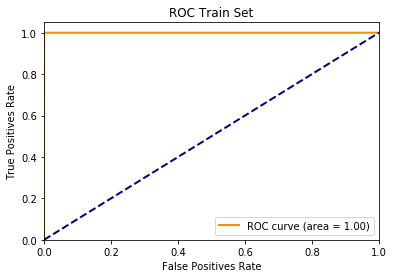

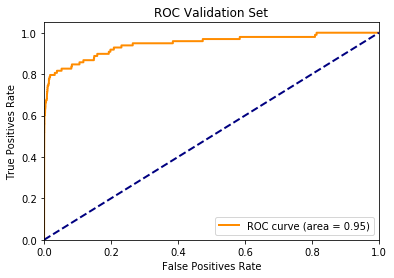

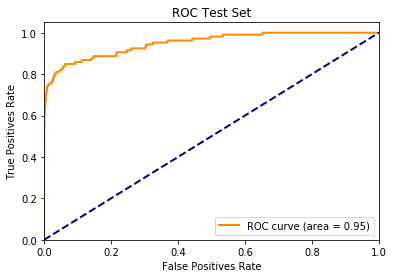

In [99]:
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Train Set')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(fpr_val, tpr_val, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Validation Set')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Test Set')
plt.legend(loc="lower right")
plt.show()

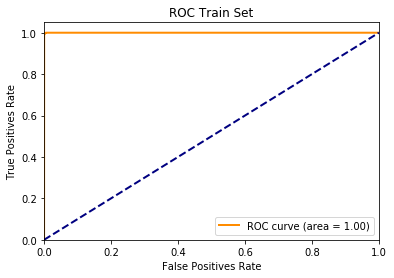

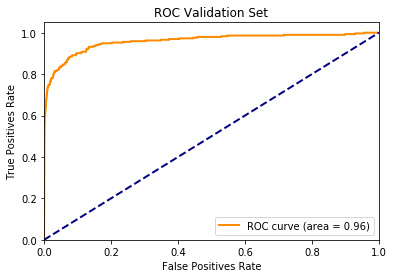

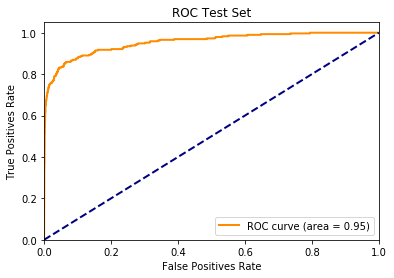

In [100]:
plt.figure()
lw = 2
plt.plot(fpr_train2, tpr_train2, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_train2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Train Set')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(fpr_val2, tpr_val2, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_val2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Validation Set')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(fpr_test2, tpr_test2, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_test2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Test Set')
plt.legend(loc="lower right")
plt.show()

In [101]:
# confusion matrix:
# tn  fp
# fn  tp
# -------
# f1 score: tp / (tp + (fp + fn)/2)
# -------
# acuracy score: (tp + tn) / (tp + fp + tn + fn)
# -------
# recall score: tp / (tp + fn)
# -------
# precision score: tp / (tp + fp)

cm_train = confusion_matrix(train_y, train_pred)
cm_val = confusion_matrix(val_y, val_pred)
cm_test = confusion_matrix(test_y, test_pred)

cm_train_pct = cm_train / cm_train.astype(np.float).sum()
cm_val_pct = cm_val / cm_val.astype(np.float).sum()
cm_test_pct = cm_test / cm_test.astype(np.float).sum()

summary = [
    ['------', 'Train', 'Validation', 'Test'],
    ['confusion matrix', cm_train, cm_val, cm_test],
    ['confusion matrix pct', cm_train_pct, cm_val_pct, cm_test_pct],
    ['f1 score', f1_score(train_y, train_pred), f1_score(val_y, val_pred), f1_score(test_y, test_pred)],
    ['accuracy score', accuracy_score(train_y, train_pred), accuracy_score(val_y, val_pred), accuracy_score(test_y, test_pred)],
    ['recall score', recall_score(train_y, train_pred), recall_score(val_y, val_pred), recall_score(test_y, test_pred)],
    ['precision score', precision_score(train_y, train_pred), precision_score(val_y, val_pred), precision_score(test_y, test_pred)]
]

pretty_table(summary)

------              	Train                            	Validation                       	Test                             
confusion matrix    	[[57169     0]                   	[[18817     7]                   	[[19002     8]                   
                    	 [    6   281]]                  	 [   53    45]]                  	 [   62    44]]                  
confusion matrix pct	[[9.95004873e-01 0.00000000e+00] 	[[9.94450904e-01 3.69939753e-04] 	[[9.94036409e-01 4.18497594e-04] 
                    	 [1.04427736e-04 4.89069897e-03]]	 [2.80097241e-03 2.37818412e-03]]	 [3.24335635e-03 2.30173677e-03]]
f1 score            	0.9894366197183099               	0.6                              	0.5569620253164558               
accuracy score      	0.9998955722639933               	0.9968290878342669               	0.9963381460556602               
recall score        	0.9790940766550522               	0.45918367346938777              	0.41509433962264153              
precision score 

In [94]:
# confusion matrix:
# tn  fp
# fn  tp
# -------
# f1 score: tp / (tp + (fp + fn)/2)
# -------
# acuracy score: (tp + tn) / (tp + fp + tn + fn)
# -------
# recall score: tp / (tp + fn)
# -------
# precision score: tp / (tp + fp)

cm_train2 = confusion_matrix(train_y2, train_pred2)
cm_val2 = confusion_matrix(val_y2, val_pred2)
cm_test2 = confusion_matrix(test_y2, test_pred2)

cm_train_pct2 = cm_train2 / cm_train2.astype(np.float).sum()
cm_val_pct2 = cm_val2 / cm_val2.astype(np.float).sum()
cm_test_pct2 = cm_test2 / cm_test2.astype(np.float).sum()

summary2 = [
    ['------', 'Train', 'Validation', 'Test'],
    ['confusion matrix', cm_train2, cm_val2, cm_test2],
    ['confusion matrix pct', cm_train_pct2, cm_val_pct2, cm_test_pct2],
    ['f1 score', f1_score(train_y2, train_pred2), f1_score(val_y2, val_pred2), f1_score(test_y2, test_pred2)],
    ['accuracy score', accuracy_score(train_y2, train_pred2), accuracy_score(val_y2, val_pred2), accuracy_score(test_y2, test_pred2)],
    ['recall score', recall_score(train_y2, train_pred2), recall_score(val_y2, val_pred2), recall_score(test_y2, test_pred2)],
    ['precision score', precision_score(train_y2, train_pred2), precision_score(val_y2, val_pred2), precision_score(test_y2, test_pred2)]
]

pretty_table(summary2)

------              	Train                            	Validation               	Test                     
confusion matrix    	[[56526    38]                   	[[18562    66]           	[[18761    64]           
                    	 [    5   887]]                  	 [  114   180]]          	 [  116   175]]          
confusion matrix pct	[[9.83813701e-01 6.61375661e-04] 	[[0.98097453 0.003488  ] 	[[0.98142917 0.00334798] 
                    	 [8.70231133e-05 1.54379003e-02]]	 [0.00602473 0.00951274]]	 [0.00606822 0.00915463]]
f1 score            	0.976334617501376                	0.6666666666666666       	0.6603773584905661       
accuracy score      	0.9992516012252854               	0.9904872635028009       	0.9905838041431262       
recall score        	0.9943946188340808               	0.6122448979591837       	0.6013745704467354       
precision score     	0.9589189189189189               	0.7317073170731707       	0.7322175732217573       
